# Clustering top URs of a specific virus type

Here, we cluster the top URs of a specific virus type. 

Run the first cell first and then the third cell (the second cell need not run, as it just prints the clusters to the screen).

For more information on the clustering tool, see UR_clst_logos.ipynb.

## Computing the clusters

In [5]:
import pandas as pd
import os, sys
import re
from Bio import motifs, SeqIO
from Bio.Seq import Seq
import matplotlib.pyplot as plt
from collections import OrderedDict
import subprocess
from pprint import pprint
import UR_host_funcs as urfuncs
import mysequtils as myut
import myseqclusters as mycl
import myseq_logo as mysl
import pald_funcs as mypal # my palindrome functions

# =====================================================================================================
base_path = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/UR_rnd_'
vfile_type = 'dsDNA'
top_num = 24 # 35  # top URs in the xlsx file
proc_type = 'neql' #'all'# 'neql' # URs to proces. Allowd values here are the keys of the return parameter from cluster_NTs function
dtype_rnd = {'signf_sorted_dsdna':str, 'tot_num_dsdna_Fall_sort':int} # columns type of xlsx file
mlens = [3, 4, 5] 

backg = {'A':0.25,'C':0.25,'G':0.25,'T':0.25}  # background for PSSM 

# Clustering tool
clst_tool = 'strc' # select a cluster tool: 'strc' for Starcode or 'mesh' for MeshClust

# starcode parameters
str_exe = '~/work/mystuff/tools/starcode/starcode'
str_clst_type = 'sp' # 'mp' for message-passing algorithm, 'sp' for sphere or 'cc' for connected-components
# MeshClust parameters
mesh_exe = '~/work/mystuff/tools/MeShClust-master/src/cluster/meshclust'
mesh_id = 0.5

clst_bfname = 'ur' # file name is clst_bfname_<vtaxid>_<mlen>.seq for UR and .clst for clusters
clst_path = './clstall_data' # will be appended with clst_tool, and in case 
                             # of Starcode, with _mp or _ph based on str_clst_type
# ==========================================================================================================
mmlens = ['m'+str(m) for m in mlens]

if clst_tool=='strc':
    print('Clustering tool selected is Starcode (algorithm is {})'.format(str_clst_type))
    clst_path += '_'+clst_tool+'_'+str_clst_type 
    clst_flags = ' -s' if str_clst_type=='sp' else ' -r 1' if str_clst_type=='mp' else ' -c -d 1'
    clst_flags += ' --print-clusters'
    clst_exe = str_exe
elif clst_tool=='mesh':
    print('Clustering tool selected is MeshClust')
    clst_path += '_'+clst_tool
    clst_flags = ' --id '+str(mesh_id)
    clst_exe = mesh_exe
else: 
    print('Cluster tool {} not supported ! Exiting...'.format(clst_tool))
    sys.exit()

bfdata = os.path.join(clst_path, clst_bfname)
os.makedirs(clst_path, exist_ok=True)

print('Using {} URs of type {}'.format(vfile_type, proc_type))

ur_clst_info = OrderedDict()
for j, mlen in enumerate(mlens):
    # load the virus URs
    xlsx_file = base_path+mmlens[j]+'_'+vfile_type+'.xlsx'
    df_vrnd = pd.read_excel(xlsx_file, header=0, dtype=dtype_rnd)
    cur_vurs = set(df_vrnd.iloc[:top_num, 0].values)  # get top URs
    clst_hurs = urfuncs.cluster_NTs(cur_vurs, mlen) # cluster them in terms of seq with only GC, AT, all nucl. equal, etc.
    proc_nt = clst_hurs[proc_type] 
    
    # clustering
    infile = '_'.join([bfdata, str(vfile_type), str(mlen)]) + '.seq'
    outfile = re.sub('.seq', '.clst', infile)
    myut.create_fasta_file(infile, proc_nt, proc_nt)  # generate input file
    # run the cluster tool
    ret, sout = mycl.run_clst_tool(clst_tool, infile, outfile, clst_exe, clst_flags)
    #print(sout)
    if ret == 0:
        # parse starcode output
        ur_clst_info[mlen] = mycl.parse_clst_tool_output(clst_tool, outfile)
    else:
        print('Clustering tool {} errored and returned: {}'.format(clst_tool, sout))
        


Clustering tool selected is Starcode (algorithm is sp)
Using dsDNA URs of type neql


## Analyze the clusters

Make sure the cell above runs before the next one.

In [7]:
# analyze the clusters
for k in ur_clst_info:
    print('clusters for m={}:'.format(k))
    val = ur_clst_info[k]
    print('number of subplots = ', sum( [len(val[kk])>1 for kk in val.keys()]))
    for i, kk in enumerate(val.keys()):
        print('  C{} ({} seq): {}'.format(i,len(val[kk]), val[kk]))



clusters for m=3:
number of subplots =  2
  C0 (14 seq): ['AGG', 'AGT', 'AAT', 'ACA', 'ACT', 'CGA', 'CGC', 'CTG', 'GCG', 'GGA', 'GTG', 'TAG', 'TCG', 'TGT']
  C1 (6 seq): ['GAC', 'GAG', 'GGC', 'GTC', 'CAA', 'CTC']
clusters for m=4:
number of subplots =  4
  C0 (11 seq): ['CGCG', 'CGAG', 'CTCC', 'CTCT', 'GCGC', 'AGCC', 'AGCT', 'CCGG', 'GGAG', 'GGCC', 'GGCT']
  C1 (3 seq): ['GCTT', 'ATTT', 'GATC']
  C2 (3 seq): ['TCGA', 'GCGA', 'TATA']
  C3 (2 seq): ['AAAT', 'AATT']
  C4 (1 seq): ['GTAC']
clusters for m=5:
number of subplots =  3
  C0 (9 seq): ['CGATC', 'AGATC', 'GGATC', 'CGCGC', 'GATCA', 'GATCC', 'GATCG', 'GATCT', 'GGGTC']
  C1 (6 seq): ['ATTTT', 'AATTT', 'CTTTT', 'TTTTA', 'TTTTC', 'TTTTG']
  C2 (3 seq): ['AAAAT', 'AAATT', 'CAAAA']
  C3 (1 seq): ['CCTGG']
  C4 (1 seq): ['GCGCG']


## Plot the logos of the clusters

Make sure the first cell runs first (the second cell need not run for this cell to execute).

Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clstall_figs_strc_sp/ur_dsDNA_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clstall_figs_strc_sp/ur_dsDNA_4.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clstall_figs_strc_sp/ur_dsDNA_5.png


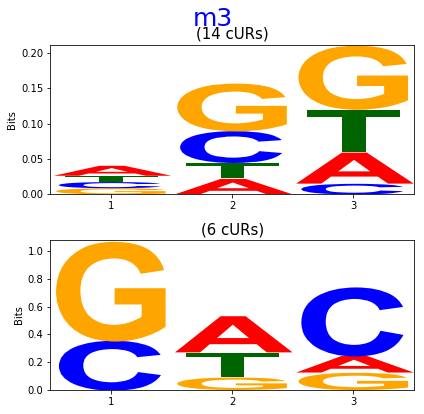

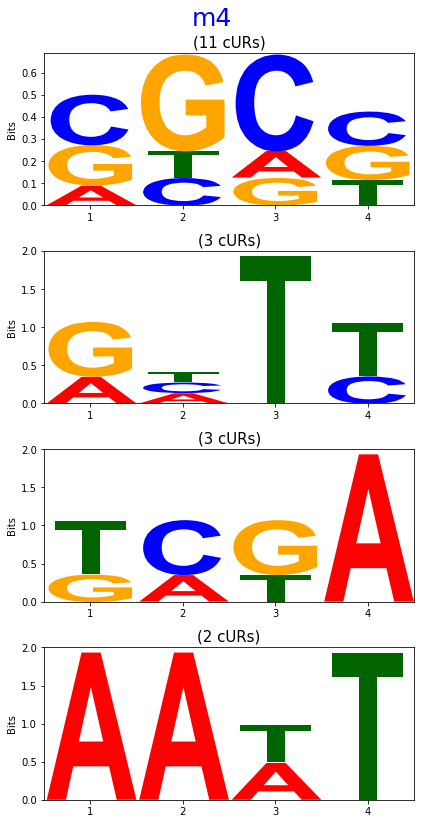

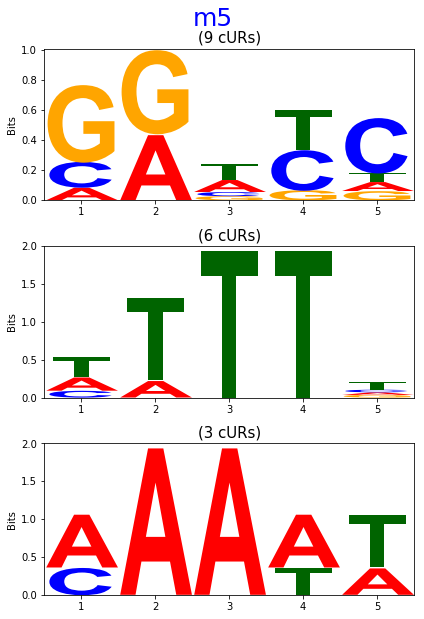

In [6]:
import matplotlib.pyplot as plt
import myseq_logo as mysl
import pald_funcs as mypal # my palindrome functions
from Bio import motifs, SeqIO
from Bio.Seq import Seq

figs_path = './clstall_figs'  # will be appended with _mp or _ph based on str_clst_type
figs_bfname = 'ur' # file name is figs_bfname_<vtaxid>_<mlen>.png
backg = {'A':0.25,'C':0.25,'G':0.25,'T':0.25}  # background for PSSM 
# =========================================================================================
figs_path += '_'+clst_tool
if clst_tool=='strc': figs_path += '_'+str_clst_type

os.makedirs(figs_path, exist_ok=True)
base_fname = os.path.join(figs_path, figs_bfname)

# ur_clst_info contains clusters information
for k in ur_clst_info:
    fname = '_'.join([base_fname, str(vfile_type), str(k)]) + '.png'
    num_urs = sum([len(v) for v in ur_clst_info[k].values()])
    # processing clusters that contain at least two sequences
    clsts = [v for v in ur_clst_info[k].values() if len(v)>1]
    fig, axs = plt.subplots(len(clsts), 1, figsize=(6, 3*len(clsts)), squeeze=False, constrained_layout=True)
    #fig.suptitle('m'+str(k)+' ('+str(num_urs)+' URs)', fontsize=25, color='blue')
    fig.suptitle('m'+str(k), fontsize=25, color='blue')
    for i, c in enumerate(clsts):
        _, _, _, m, _ = mysl.compute_pssm(c, backg, backg)
        rel_info = mysl.calc_rel_info(m, 'no')
        maxy = mysl.gen_nt_sequence_logo(axs[i,0], rel_info)
        axs[i,0].set_title('('+str(len(c))+' cURs)', fontsize=15, color='black')
        axs[i,0].set_ylabel('Bits')
        axs[i,0].axis([0.5, k+0.5, 0, maxy])
        axs[i,0].set_xticks(range(1, k+1))

    #plt.tight_layout()
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    #plt.subplots_adjust(wspace=0.8, top=0.8)
    # save plot
    plt.savefig(fname, dpi=200)
    path = !pwd  # shell command
    print('Figure saved in {}/{}'.format(path[0], fname))

